In [255]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [256]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(dataset, original, generated):
    original = np.reshape(original, [original.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(original.shape[0])))
    
    fig = plt.figure(figsize=(2*sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, 2*sqrtn + 1)
    gs.update(wspace=0.05, hspace=0.05)
    
    if dataset == "mnist":
        shape = [28,28] 
    elif dataset == "cifar":
        shape = [32,32,3]

    for i, img in enumerate(original):
        ax = plt.subplot(gs[i // sqrtn, i % sqrtn])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(rescale_img(img.reshape(shape)))
    
    for i, img in enumerate(generated):
        ax = plt.subplot(gs[i // sqrtn, 1 + i % sqrtn + sqrtn])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(rescale_img(img.reshape(shape)))
    
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rescale_img(x):
    if (np.min(x) < 0) or (1 < np.max(x)): 
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    else:
        return x

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [257]:
class DATA(object):
    def __init__(self, dataset, batch_size, shuffle=False):
        
        if dataset == "mnist":
            train, test = tf.keras.datasets.mnist.load_data() 
        elif dataset == "cifar":
            train, test = tf.keras.datasets.cifar10.load_data()
        
        X_train, y_train = train
        X_train = X_train.astype(np.float32)/255
        X_train = X_train.reshape((X_train.shape[0], -1))
        self.X_train, self.y_train = X_train, y_train.squeeze()
        
        X_test, y_test = test
        X_test = X_test.astype(np.float32)/255
        X_test = X_test.reshape((X_test.shape[0], -1))
        self.X_test, self.y_test = X_test, y_test.squeeze()
        
        self.mode = "train";
        
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        if self.mode == "train":
            N, B = self.X_train.shape[0], self.batch_size
        else:
            N, B = self.X_test.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        if self.mode == "train":
            return iter((self.X_train[i:i+B], self.y_train[i:i+B]) for i in range(0, N, B))
        else:
            return iter((self.X_test[i:i+B], self.y_test[i:i+B]) for i in range(0, N, B))

In [271]:
class ADVERSARIAL(object):
    def __init__(self, dataset, batch_size, shuffle=False):
        
        if dataset == "mnist":
            data = np.load("mnist.npz")
        elif dataset == "cifar":
            data = np.load("cifar.npz")

        self.y = data['original_labels']
        self.X = data['adversarial_images'].transpose([0,2,3,1]).reshape([self.y.size,-1])
        
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

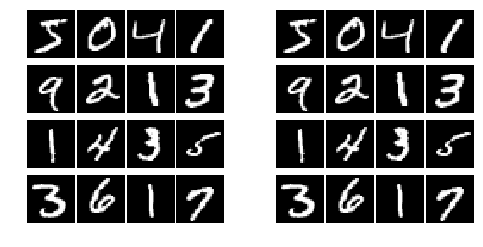

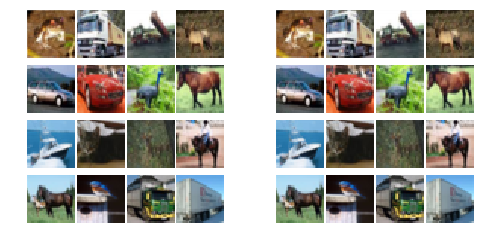

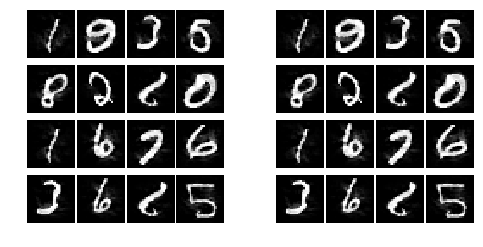

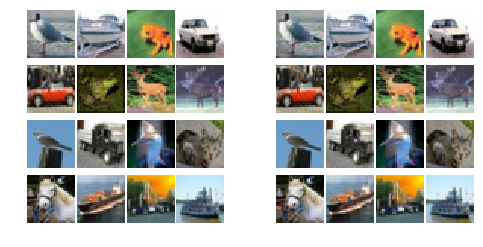

In [272]:
mnist = DATA("mnist", batch_size=16)
cifar = DATA("cifar", batch_size=16)
adv_mnist = ADVERSARIAL("mnist", batch_size=16)
adv_cifar = ADVERSARIAL("cifar", batch_size=16)
show_images("mnist", mnist.X_train[:16], mnist.X_train[:16])
show_images("cifar", cifar.X_train[:16], cifar.X_train[:16])
show_images("mnist", adv_mnist.X[:16], adv_mnist.X[:16])
show_images("cifar", adv_cifar.X[:16], adv_cifar.X[:16])

In [259]:
def classifier(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("classifier"):
        h1 = tf.layers.dense(x,256,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,256,activation=tf.nn.relu)
        logits = tf.layers.dense(h2,10,activation=None)
        return logits

In [260]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        h1 = tf.layers.dense(x,256,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,256,activation=tf.nn.relu)
        logits = tf.layers.dense(h2,10,activation=None)
        return logits
#     with tf.variable_scope("discriminator"):
#         z = tf.reshape(x,[-1,28,28,1])
#         h1 = tf.layers.conv2d(z,32,[5,5], activation=tf.nn.relu)
#         h2 = tf.layers.max_pooling2d(h1,[2,2],2)
#         h3 = tf.layers.conv2d(h2,64,[5,5], activation=tf.nn.relu)
#         h4 = tf.layers.max_pooling2d(h3,[2,2],2)
#         h5 = tf.layers.flatten(h4)
#         h6 = tf.layers.dense(h5,1024,activation=tf.nn.relu)
#         logits = tf.layers.dense(h6,10,activation=None)
        
#         return logits

In [261]:
def generator(z, size):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        h1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        h2 = tf.layers.dense(h1, 1024, activation=tf.nn.relu)
        img = tf.layers.dense(h2, size, activation=tf.nn.tanh)
        return img
#     with tf.variable_scope("generator"):
#         h1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
#         h2 = tf.layers.batch_normalization(h1, training=True)
#         h3 = tf.layers.dense(h2, 6272, activation=tf.nn.relu)
#         h4 = tf.layers.batch_normalization(h3, training=True)
#         h5 = tf.reshape(h4,[-1,7,7,128])
#         h6 = tf.layers.conv2d_transpose(h5,64,[4,4],2,'same',activation=tf.nn.relu)
#         h7 = tf.layers.batch_normalization(h6, training=True)
#         img = tf.layers.conv2d_transpose(h7,1,[4,4],2,'same',activation=tf.nn.tanh)
#         return img

In [262]:
def loss(logits, y):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    C_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    
    return C_loss

In [263]:
def gan_loss(logits_real, logits_fake, x, Gx, y, alpha):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    loss_real = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_real)
    loss_fake = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_fake)
    
    D_loss = tf.reduce_mean(loss_real) + tf.reduce_mean(loss_fake)
    G_loss = -tf.reduce_mean(loss_fake) + alpha * tf.losses.mean_squared_error(x, Gx)
    
    return D_loss, G_loss

In [264]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    C_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    
    return C_solver, D_solver, G_solver

In [268]:
tf.reset_default_graph()

feature = 784

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, feature])
# placeholder for labels from the training dataset
y = tf.placeholder(tf.int32, [None,])
# generated images
Gx = generator(x, feature)


logits = classifier(preprocess_img(x))

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(Gx)

# Get the list of variables for the discriminator and generator
C_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'classifier') 
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
C_solver, D_solver, G_solver = get_solvers()

# get our loss
C_loss = loss(logits, tf.one_hot(y, 10))
D_loss, G_loss = gan_loss(logits_real, logits_fake, x, Gx, tf.one_hot(y, 10), 100)

# setup training steps
C_train_step = C_solver.minimize(C_loss, var_list=C_vars)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

# predict and calc accuracy
C_preds = tf.nn.softmax(logits_real)
C_correct_preds = tf.equal(tf.argmax(C_preds, 1), tf.argmax(tf.one_hot(y, 10), 1))
C_accuracy = tf.reduce_sum(tf.cast(C_correct_preds, tf.float32)) / tf.to_float(tf.shape(x)[0])

D_preds = tf.nn.softmax(logits)
D_correct_preds = tf.equal(tf.argmax(D_preds, 1), tf.argmax(tf.one_hot(y, 10), 1))
D_accuracy = tf.reduce_sum(tf.cast(D_correct_preds, tf.float32)) / tf.to_float(tf.shape(x)[0])

In [269]:
# a giant helper function
def run_gan(dataset, sess, G_train_step, G_loss, D_train_step, D_loss,\
              show_every=2, print_every=1, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    mnist = DATA(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        # every show often, show a sample result
        if epoch % show_every == 0:
            samples = sess.run(Gx, feed_dict={x: mnist.X_test})
            fig = show_images(dataset,mnist.X_test[:16],samples[:16])
            plt.show()
            print()
        for (minibatch_x, minibatch_y) in mnist:
            # run a batch of data through the network
            _, C_loss_curr = sess.run([C_train_step, C_loss], feed_dict={x: minibatch_x, y: minibatch_y})
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch_x, y: minibatch_y})
            _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch_x, y: minibatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, C: {:.4}, D: {:.4}, G:{:.4}'.format(epoch,C_loss_curr,D_loss_curr,G_loss_curr))
    print('Final Test Generated Images')
    samples = sess.run(Gx, feed_dict={x: mnist.X_test})
    fig = show_images(dataset,mnist.X_test[:16],samples[:16])
    plt.show()
    
    adv = ADVERSARIAL(dataset, batch_size=batch_size, shuffle=True)
    
    # Classifier Accuracy
    train_accuracy = sess.run(C_accuracy, feed_dict={x: mnist.X_train, y: mnist.y_train})
    test_accuracy = sess.run(C_accuracy, feed_dict={x: mnist.X_test, y: mnist.y_test})
    print('Classifier: Train Accuracy: {:.4}, Test Accuracy: {:.4}'.format(train_accuracy,test_accuracy))
    robustness = sess.run(C_accuracy, feed_dict={x: adv.X, y: adv.y})
    print('Classifier: Adversarial Accuracy: {:.4}'.format(robustness))
    
    # Descriminator Accuracy
    train_accuracy = sess.run(D_accuracy, feed_dict={x: mnist.X_train, y: mnist.y_train})
    test_accuracy = sess.run(D_accuracy, feed_dict={x: mnist.X_test, y: mnist.y_test})
    print('Descriminator: Train Accuracy: {:.4}, Test Accuracy: {:.4}'.format(train_accuracy,test_accuracy))
    robustness = sess.run(D_accuracy, feed_dict={x: adv.X, y: adv.y})
    print('Descriminator: Adversarial Accuracy: {:.4}'.format(robustness))

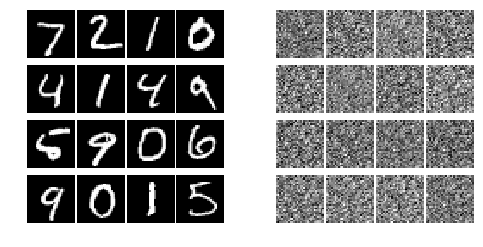


Epoch: 0, C: 0.4206, D: 2.378, G:1.647
Epoch: 1, C: 0.2547, D: 2.429, G:1.191


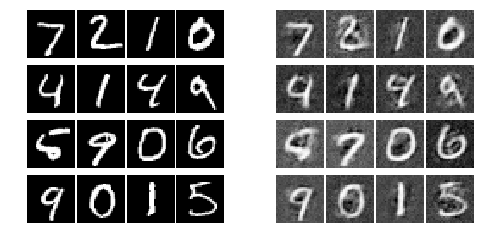


Epoch: 2, C: 0.206, D: 1.984, G:0.877
Epoch: 3, C: 0.1792, D: 1.836, G:0.8301


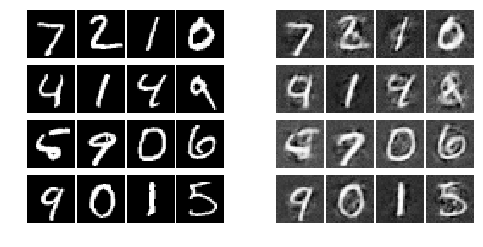


Epoch: 4, C: 0.1707, D: 1.73, G:0.7323
Epoch: 5, C: 0.1955, D: 1.696, G:0.9473


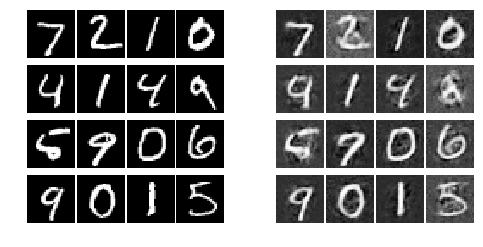


Epoch: 6, C: 0.1426, D: 1.546, G:0.6593
Epoch: 7, C: 0.1503, D: 1.444, G:0.5906


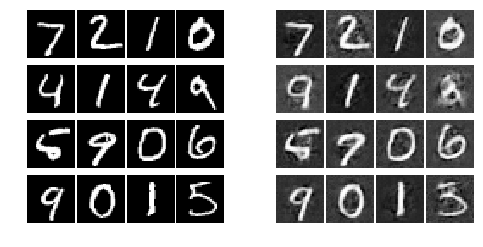


Epoch: 8, C: 0.1177, D: 1.321, G:0.5862
Epoch: 9, C: 0.1407, D: 1.323, G:0.5508
Final Test Generated Images


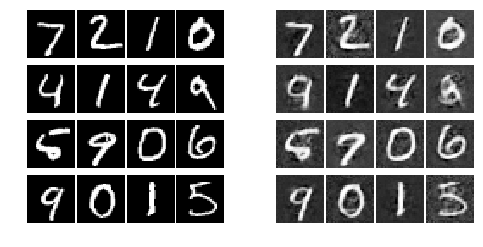

Classifier: Train Accuracy: 0.9883, Test Accuracy: 0.98
Classifier: Adversarial Accuracy: 0.9714
Descriminator: Train Accuracy: 0.9868, Test Accuracy: 0.9762
Descriminator: Adversarial Accuracy: 0.9541


In [270]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_gan("mnist",sess,G_train_step,G_loss,D_train_step,D_loss)